In [1]:
import pandas as pd, requests, time
import numpy as np

import datetime

import geopy
from geopy.geocoders import GoogleV3

import shapefile as shp
from shapely.geometry import Point, Polygon

import pyproj
from pyproj import CRS

import warnings
warnings.filterwarnings('ignore')


In [2]:
class Data:
    ndev = 2
    # allow indexing
    can = [None] * ndev
    pos = [None] * ndev
    canQ2 = [None] * ndev
    posQ2 = [None] * ndev
    canQ3 = [None] * ndev
    posQ3 = [None] * ndev
    canQ4 = [None] * ndev
    posQ4 = [None] * ndev
    can_2020 = [None] * ndev
    pos_2020 = [None] * ndev
    can_2021 = [None] * ndev
    pos_2021 = [None] * ndev
    canQ4_21Q2 = [None] * ndev
    posQ4_21Q2 = [None] * ndev
   # periods=['2020_Q1','2020_Q2','2020_Q3']
# I pass Q1 of 2020 to start with
def ravoEquipement_read_files(periods):
    for i in range(Data.ndev):
        if i == 0:
            ravo = 'Stadwerk072_5170'
        elif i == 1:
            ravo = 'Stadwerk072_5173'
        for period in periods:
            if period =='2020_Q1':
                Data.can[i] = pd.read_csv('../ravo/'+ period +'/'+ ravo + '/can.csv', delimiter=';', index_col='#', parse_dates=True)
                Data.pos[i] = pd.read_csv('../ravo/'+ period +'/'+ ravo + '/positions.csv', delimiter=';', index_col='#', parse_dates=True)
            elif period == '2020_Q2':
                Data.canQ2[i] = pd.read_csv('../ravo/'+ period +'/'+ ravo + '/can.csv', delimiter=';', index_col='#', parse_dates=True)
                Data.posQ2[i] = pd.read_csv('../ravo/'+ period +'/'+ ravo + '/positions.csv', delimiter=';', index_col='#', parse_dates=True)
            elif period == '2020_Q3':
                Data.canQ3[i] = pd.read_csv('../ravo/'+ period +'/'+ ravo + '/can.csv', delimiter=';', index_col='#', parse_dates=True)
                Data.posQ3[i] = pd.read_csv('../ravo/'+ period +'/'+ ravo + '/positions.csv', delimiter=';', index_col='#', parse_dates=True)
            elif period == '2020_Q4_to_2021_Q2':
                Data.canQ4_21Q2[i] = pd.read_csv('../ravo/'+ period +'/'+ ravo + '/can.csv', delimiter=';', index_col='#', parse_dates=True)
                Data.posQ4_21Q2[i] = pd.read_csv('../ravo/'+ period +'/'+ ravo + '/positions.csv', delimiter=';', index_col='#', parse_dates=True)
ravoEquipement_read_files(['2020_Q1','2020_Q2','2020_Q3','2020_Q4_to_2021_Q2'])   


#### Q4 2020 sensor data and in the same files with the 2021 data, thus we will separate them and merge data with the same year

In [3]:
dataframes_list= [Data.can,Data.pos,Data.canQ2,Data.posQ2,Data.canQ3,Data.posQ3,Data.canQ4_21Q2, Data.posQ4_21Q2]

# Custom function to handle timestamp column

def TimestmpToDateTime(dataframe):
    for i in range(Data.ndev):
        dataframe[i]['Timestamp']=pd.to_datetime(dataframe[i]['Timestamp'])    
        dataframe[i]['date']= dataframe[i].Timestamp.apply(lambda x: datetime.datetime.date(x))
        

In [4]:
for df in dataframes_list:
    TimestmpToDateTime(df)

##### Then use the Date column to separate Q4 data from the dataframe

In [5]:
start_date_Q4= pd.to_datetime('2020-09-29')
end_date_Q4= pd.to_datetime('2020-12-31')

start_date_2021= pd.to_datetime('2020-12-31')
end_date_2021= pd.to_datetime('2021-12-31')

for i in range(Data.ndev):
    Data.canQ4[i]=Data.canQ4_21Q2[i].loc[(Data.canQ4_21Q2[i].date > start_date_Q4) & (Data.canQ4_21Q2[i].date <= end_date_Q4)]
    Data.posQ4[i]=Data.posQ4_21Q2[i].loc[(Data.posQ4_21Q2[i].date > start_date_Q4) & (Data.posQ4_21Q2[i].date <= end_date_Q4)]
    
    Data.can_2021[i]=Data.canQ4_21Q2[i].loc[(Data.canQ4_21Q2[i].date > start_date_2021) & (Data.canQ4_21Q2[i].date <= end_date_2021)]
    Data.pos_2021[i]=Data.posQ4_21Q2[i].loc[(Data.posQ4_21Q2[i].date > start_date_2021) & (Data.posQ4_21Q2[i].date <= end_date_2021)]  

##### Now 2021 data begin with january 2021 and not September 2020 

In [6]:
Data.can_2021[i].head()

,Equipment Name,Timestamp,Brush Speed [%],Service Timer [h],Engine hours [h],Engine Speed [RPM],Hydro Oil Temp [°C],5i/e Odometer_ [Km],5i/e Odometer Sweep_ [Km],Vehicle Speed [Km/h],...,Fuel Level [%],Engine Coolant Temp [°C],Park Brake Pressure [kPa],Ambient Temp [°C],Fuel Consumption [L/h],Brake Pressure [kPa],Water Tank Level [%],FAN Status [STATUS],FAN Stat,date
#,,,,,,,,,,,,,,,,,,,,,
5397,Stadwerk072 (5173),2021-01-02 05:16:46+00:00,0.0,5.0,3514.60,1148.63,9.0,20236.94,7324.37,11.42,...,99.6,53.0,4300.0,4.69,7.85,15700.0,99.0,0.0,NaN,2021-01-02
5398,Stadwerk072 (5173),2021-01-02 05:21:46+00:00,0.0,5.0,3514.70,1642.88,23.0,20239.50,7324.37,27.12,...,100.0,76.0,3700.0,5.28,12.70,15700.0,97.0,0.0,NaN,2021-01-02
5399,Stadwerk072 (5173),2021-01-02 05:26:47+00:00,87.0,5.0,3514.80,1763.75,24.0,20239.97,7324.68,2.60,...,100.0,90.0,4100.0,4.69,14.95,17300.0,95.0,1.0,NaN,2021-01-02
5400,Stadwerk072 (5173),2021-01-02 05:31:46+00:00,0.0,5.0,3514.85,1135.75,25.0,20240.14,7324.85,0.00,...,100.0,87.0,0.0,4.50,5.70,17000.0,93.0,0.0,NaN,2021-01-02
5401,Stadwerk072 (5173),2021-01-02 05:33:24+00:00,0.0,5.0,3514.90,1543.13,25.0,20240.22,7324.93,0.00,...,100.0,87.0,0.0,4.78,11.50,16900.0,94.0,0.0,NaN,2021-01-02


#### Save the Q4 and 2021 data in csv files

In [7]:
# for i in range(Data.ndev):
#     if i == 0:
#            ravo = 'Stadwerk072_5170'
#     elif i == 1:
#            ravo = 'Stadwerk072_5173'
#     Data.posQ4[i].to_csv('../ravo/2020_Q4/'+ ravo+'/positions.csv')
#     Data.canQ4[i].to_csv('../ravo/2020_Q4/'+ ravo+'/can.csv')
    
#     Data.pos_2021[i].to_csv('../ravo/2021/'+ ravo+'/positions.csv')
#     Data.can_2021[i].to_csv('../ravo/2021/'+ ravo+'/can.csv')

#### Inspect the columns and choose which ones we need for analysis

In [8]:
print("Differences in number of columns:\n")
for i in range(Data.ndev):   
    if i == 0:
            ravo = '5170'
    elif i == 1:
            ravo = '5173'
    print("Q1_2020 {} Can: {}\t Position: {}".format(ravo, len(Data.can[i].columns), len(Data.pos[i].columns)))
    print("Q2_2020 {} Can: {}\t Position: {}".format(ravo, len(Data.canQ2[i].columns), len(Data.posQ2[i].columns)))
    print("Q3_2020 {} Can: {}\t Position: {}".format(ravo, len(Data.canQ3[i].columns), len(Data.posQ3[i].columns)))
    print("Q4_2020 {} Can: {}\t Position: {}".format(ravo, len(Data.canQ4[i].columns), len(Data.posQ4[i].columns)))
    print("2021 \t{} Can: {}\t Position: {}".format(ravo, len(Data.canQ4[i].columns), len(Data.posQ4[i].columns)))
    print("Q1_2020 {} Can: {}\t Position: {}".format(ravo, len(Data.can_2021[i].columns), len(Data.pos_2021[i].columns)))    
   

Differences in number of columns:

Q1_2020 5170 Can: 25	 Position: 8
Q2_2020 5170 Can: 25	 Position: 8
Q3_2020 5170 Can: 30	 Position: 8
Q4_2020 5170 Can: 44	 Position: 8
2021 	5170 Can: 44	 Position: 8
Q1_2020 5170 Can: 44	 Position: 8
Q1_2020 5173 Can: 25	 Position: 8
Q2_2020 5173 Can: 25	 Position: 8
Q3_2020 5173 Can: 30	 Position: 8
Q4_2020 5173 Can: 31	 Position: 8
2021 	5173 Can: 31	 Position: 8
Q1_2020 5173 Can: 31	 Position: 8


###### Some dataframes have same number of columns and others not. Let's check symetric differences in column names, get unique ones and try to make our dataframes uniform 

In [9]:
print('difference Q1 and Q2 data: \n',set(Data.can[0].columns).symmetric_difference(Data.canQ2[0].columns),'\n')
print('difference Q1 and Q3 data: \n',set(Data.can[0].columns).symmetric_difference(Data.canQ3[0].columns),'\n')
print('difference Q1 and Q4 data: \n',set(Data.can[0].columns).symmetric_difference(Data.canQ4[0].columns))

difference Q1 and Q2 data: 
 set() 

difference Q1 and Q3 data: 
 {'Engine Oil Pressure SPN 100 [kPa]', '5i/e Pressure 3rBrush System [kPa]', '5i/e Pressure ParkBrake System [kPa]', '5i/e Pressure BrakeSystem [kPa]', 'Engine Air Intake Manifol press SPN 102 [kPa]'} 

difference Q1 and Q4 data: 
 {'Engine Air Intake Manifold Press [kPa]', 'Vehicle Speed [Km/h]', 'SAIGA mA [mA]', 'Brush Speed [%]', 'Engine Coolant Temp SPN 110 [°C]', '5i/e Brushes status', '5i ATF Status', 'SERVICE CODE 1 [STATUS]', 'Odometer Sweep [Km]', 'FAN Status [STATUS]', 'SAIGA Status [STATUS]', 'Fuel consumption SPN183 [L/h]', 'Ambient temp SPN 171 [°C]', 'Engine Torque Actual SPN 513 [%]', 'Sweep Time [h]', 'STATUS CODE 1 [STATUS]', '5i/e Suction Nozzle Down', 'DEF - Catalist level SPN 1761 [%]', 'Engine Coolant Temp [°C]', '5i/e Water Tank Level [%]', 'SAIGA Voltage [kV]', 'Engine Speed SPN 190 [RPM]', '5i/e Brush Speed [%]', 'Odometer [Km]', 'Water Tank Level [%]', '3rBrush System Pressure [kPa]', '5i/e FAN [S

###### It is clear that for the 'can' dataframes only Q1 and Q2 data columns names are same, others have different column names. We will try to manually clean the column names from the Q4 an 2021 which will add value to our analysis so they are uniform accros the dataset; for Ex: columns 'Brush Speed [%]' and '5i/e Brush Speed [%]' are the same but different names), then we will drop some columns that are not needed in our analysis.

In [10]:
for i in range(Data.ndev):
    Data.canQ4[i].rename({'Brush Speed [%]': '5i/e Brush Speed [%]','Odometer Sweep [Km]': '5i/e Odometer Sweep_ [Km]'}, axis=1, inplace=True)
    Data.can_2021[i].rename({'Brush Speed [%]': '5i/e Brush Speed [%]','Odometer Sweep [Km]': '5i/e Odometer Sweep_ [Km]'}, axis=1, inplace=True)

###### Let's take only common columns and leave the rest of columns out. Let's first see which columns names are present in all the dataframes by taking the intersection of all dataframe's columns

In [11]:
Common_columns_5170= set(Data.can[0].columns).intersection(Data.canQ2[0].columns,Data.canQ3[0].columns,Data.canQ4[0].columns, Data.can_2021[0].columns)
Common_columns_5173= set(Data.can[1].columns).intersection(Data.canQ2[1].columns,Data.canQ3[1].columns,Data.canQ4[1].columns, Data.can_2021[1].columns)

print('Common column names can[0]: \n\t {} \t Number of match: {}\n'.format(Common_columns_5170, len(Common_columns_5170)))
print('Common column names can[1]: \n\t {} \t Number of match: {}\n'.format(Common_columns_5173,len(Common_columns_5173)))

Common column names can[0]: 
	 {'Equipment Name', '5i/e Odometer Sweep_ [Km]', '5i/e Operation Hours_ [h]', '5i/e Sweep time_ [h]', 'date', '5i Flexfan DutyCylce [%]', '5i/e Odometer_ [Km]', '5i/e Machine Status J1939', '5i/e Machine Status', 'Timestamp', '5i/e Brush Speed [%]'} 	 Number of match: 11

Common column names can[1]: 
	 {'Equipment Name', '5i/e Odometer Sweep_ [Km]', '5i/e Operation Hours_ [h]', '5i/e Sweep time_ [h]', 'date', '5i/e Odometer_ [Km]', '5i/e Machine Status J1939', '5i/e Machine Status', 'Timestamp', '5i/e Brush Speed [%]'} 	 Number of match: 10



###### Only 10 columns match accross the dataframes

###### We will take the subset of each of the dataframes with the matched columns

In [12]:
matched_columns=['Equipment Name','Timestamp','5i/e Machine Status','5i/e Machine Status J1939','5i/e Brush Speed [%]','5i/e Sweep time_ [h]','5i/e Odometer_ [Km]', '5i/e Operation Hours_ [h]','date']

for i in range(Data.ndev):
    Data.can[i]=Data.can[i][matched_columns]
    Data.canQ2[i]=Data.canQ2[i][matched_columns]
    Data.canQ3[i]=Data.canQ3[i][matched_columns]
    Data.canQ4[i]=Data.canQ4[i][matched_columns]
    Data.can_2021[i]=Data.can_2021[i][matched_columns]
    

In [13]:
len(matched_columns)

9

##### Merge all data per year and rename column names

In [14]:
for i in range(Data.ndev):
    Data.pos_2020[i]= pd.concat([Data.pos[i],Data.posQ2[i],Data.posQ3[i],Data.posQ4[i]], ignore_index=True)
    Data.pos_2020[i]=Data.pos_2020[i].rename(columns={'Equipment Name': 'Equipment_name', 'Equipment Status': 'Equipment_status', 'Message Types': 'Message_types'}, index={'#': 'Number'})
    
    Data.pos_2021[i]=Data.pos_2021[i].rename(columns={'Equipment Name': 'Equipment_name', 'Equipment Status': 'Equipment_status', 'Message Types': 'Message_types'}, index={'#': 'Number'})
    
    

In [15]:
Data.can_2021[0].head()

,Equipment Name,Timestamp,5i/e Machine Status,5i/e Machine Status J1939,5i/e Brush Speed [%],5i/e Sweep time_ [h],5i/e Odometer_ [Km],5i/e Operation Hours_ [h],date
#,,,,,,,,,
3908,Stadwerk072 (5170),2021-01-04 05:55:18+00:00,TRANSPORT,TRANSPORT,0.0,NaN,NaN,NaN,2021-01-04
3909,Stadwerk072 (5170),2021-01-04 06:00:18+00:00,TRANSPORT,TRANSPORT,0.0,NaN,NaN,NaN,2021-01-04
3910,Stadwerk072 (5170),2021-01-04 06:05:17+00:00,SWEEP,SWEEP,71.0,NaN,NaN,NaN,2021-01-04
3911,Stadwerk072 (5170),2021-01-04 06:10:18+00:00,SWEEP,SWEEP,71.0,NaN,NaN,NaN,2021-01-04
3912,Stadwerk072 (5170),2021-01-04 06:15:18+00:00,SWEEP,SWEEP,71.0,NaN,NaN,NaN,2021-01-04


###### Combine latitude and longitude as a new feature, this will be used to get addresses of the points 

In [16]:
for i in range(Data.ndev):
    Data.pos[i].loc[:,'latlon'] = Data.pos[i].loc[:,'Latitude'].map(str) + ',' + Data.pos[i].loc[:,'Longitude'].map(str)
    Data.posQ2[i].loc[:,"latlon"] = Data.posQ2[i].loc[:,'Latitude'].map(str) + ',' + Data.posQ2[i].loc[:,'Longitude'].map(str)
    Data.posQ3[i].loc[:,"latlon"] = Data.posQ3[i].loc[:,'Latitude'].map(str) + ',' + Data.posQ3[i].loc[:,'Longitude'].map(str)
    Data.posQ4[i].loc[:,"latlon"] = Data.posQ4[i].loc[:,'Latitude'].map(str) + ',' + Data.posQ4[i].loc[:,'Longitude'].map(str)
    Data.pos_2021[i].loc[:,"latlon"] = Data.pos_2021[i].loc[:,'Latitude'].map(str) + ',' + Data.pos_2021[i].loc[:,'Longitude'].map(str)

In [17]:
Data.pos_2021[0].head()

,Equipment_name,Timestamp,Equipment_status,Message_types,Latitude,Longitude,Heading,date,latlon
#,,,,,,,,,
26289,Stadwerk072 (5170),2021-01-01 00:39:20+00:00,OFF,Wake,52.62000,4.76756,180,2021-01-01,"52.62,4.76756"
26290,Stadwerk072 (5170),2021-01-01 00:42:43+00:00,OFF,Sleep,52.61979,4.76760,180,2021-01-01,"52.61979,4.7676"
26291,Stadwerk072 (5170),2021-01-01 12:39:46+00:00,OFF,Wake,52.61979,4.76760,(null),2021-01-01,"52.61979,4.7676"
26292,Stadwerk072 (5170),2021-01-01 12:42:43+00:00,OFF,Sleep,52.61991,4.76748,172,2021-01-01,"52.61991,4.76748"
26293,Stadwerk072 (5170),2021-01-02 00:39:47+00:00,OFF,Wake,52.61991,4.76748,(null),2021-01-02,"52.61991,4.76748"


In [18]:
def number_to_monthName(num):
    return ["January","February","March","April","May","June","July","August","September","October","November","December"][num - 1]
def number_to_weekday(num):
    return ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"][num]

def derive_date_features(df):
    if(df['Timestamp'].dtypes==object):
        df['Timestamp']=pd.to_datetime(df['Timestamp'])
    df['date']= df.Timestamp.apply(lambda x: datetime.datetime.date(x))
    df["year"] = df["Timestamp"].apply(lambda x:x.year)
    df["day"] = df["Timestamp"].apply(lambda x:x.day)
    df["month"] = df["Timestamp"].apply(lambda x:number_to_monthName(x.month))
    df["weekday"] = df["Timestamp"].apply(lambda x:number_to_weekday(x.weekday()))
    
for i in range(Data.ndev): 
    derive_date_features(Data.pos_2020[i])
    derive_date_features(Data.pos_2021[i])
    
    

###### Reset the index of the 2021 dataframe and rename columns

In [19]:
Data.pos_2021[0]=Data.pos_2021[0].reset_index(drop=True)
Data.pos_2021[1]=Data.pos_2021[1].reset_index(drop=True)

In [20]:
Data.pos_2020[0]

,Equipment_name,Timestamp,Equipment_status,Message_types,Latitude,Longitude,Heading,date,year,day,month,weekday
0,Stadwerk072 (5170),2020-01-01 09:55:04+00:00,OFF,Wake,52.61909,4.76726,0.0,2020-01-01,2020,1,January,Wednesday
1,Stadwerk072 (5170),2020-01-01 09:58:33+00:00,OFF,Sleep,52.61916,4.76772,0.0,2020-01-01,2020,1,January,Wednesday
2,Stadwerk072 (5170),2020-01-01 21:54:57+00:00,OFF,Wake,52.61920,4.76842,0.0,2020-01-01,2020,1,January,Wednesday
3,Stadwerk072 (5170),2020-01-01 21:58:29+00:00,OFF,Sleep,52.61907,4.76823,0.0,2020-01-01,2020,1,January,Wednesday
4,Stadwerk072 (5170),2020-01-02 09:55:37+00:00,OFF,Wake,52.61916,4.76784,0.0,2020-01-02,2020,2,January,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...
75804,Stadwerk072 (5170),2020-12-30 12:42:41+00:00,OFF,Sleep,52.61909,4.76722,348,2020-12-30,2020,30,December,Wednesday
75805,Stadwerk072 (5170),2020-12-31 00:39:34+00:00,OFF,Wake,52.61898,4.76781,0,2020-12-31,2020,31,December,Thursday
75806,Stadwerk072 (5170),2020-12-31 00:42:41+00:00,OFF,Sleep,52.61904,4.76754,226,2020-12-31,2020,31,December,Thursday
75807,Stadwerk072 (5170),2020-12-31 12:39:31+00:00,OFF,Wake,52.61907,4.76685,0,2020-12-31,2020,31,December,Thursday


###### Some columns contains null values, hence they may misguide us in our analysis if used

In [21]:
Data.pos_2020[0].isna().sum()


Equipment_name          0
Timestamp               0
Equipment_status      699
Message_types       59004
Latitude                0
Longitude               0
Heading              2609
date                    0
year                    0
day                     0
month                   0
weekday                 0
dtype: int64

In [22]:
Data.pos_2020[0].Message_types.value_counts(dropna=False)

NaN                                     59004
Report Status,CAN                       10309
Sleep                                    1081
Key ON                                   1060
Key OFF,Report Status,CAN                1053
ON Message                                996
DM1                                       556
CAN                                       549
Wake                                      534
Report Status                             510
CAN,Report Status                         113
DM1,Key ON                                 16
Key OFF                                    10
ON Message,Key OFF,Report Status,CAN       10
Key OFF,Report Status,CAN,ON Message        4
CAN,Key OFF,Report Status                   2
ON Message,Key ON                           1
DM1,Report Status,CAN                       1
Name: Message_types, dtype: int64

In [23]:
 Data.pos_2020[0].Heading.value_counts(dropna=False)

(null)    3062
NaN       2609
0.0       1398
0          637
272.0      604
          ... 
156         57
340         56
152         54
360.0       12
360          1
Name: Heading, Length: 364, dtype: int64

In [24]:
Data.pos_2020[0].Equipment_status.value_counts(dropna=False)

HIGH Working         33108
Travel               27282
Working               6986
ON / Idle             3634
OFF                   2718
NaN                    699
Key ON/Engine OFF      620
Long Idle              480
(null)                 280
Light Workload           2
Name: Equipment_status, dtype: int64

###### Dropping columns: Heading and Message_type columns, as their null/nan values dominates other values, and looking on values both columns provide little information. Equipment_status column will be assessed further

In [25]:
for i in range(Data.ndev):
    Data.pos_2020[i]=Data.pos_2020[i].drop(['Heading','Message_types'], axis=1)
    Data.pos_2021[i]=Data.pos_2021[i].drop(['Heading','Message_types'], axis=1)

###### Deriving new features that will help in the analysis

In [26]:
Data.pos_2021[0].rename({'Unnamed: 0': '#'},axis=1, inplace=True)

In [27]:
Data.pos_2021[0].columns

Index(['Equipment_name', 'Timestamp', 'Equipment_status', 'Latitude',
       'Longitude', 'date', 'latlon', 'year', 'day', 'month', 'weekday'],
      dtype='object')

In [28]:
Data.pos_2021[0]

,Equipment_name,Timestamp,Equipment_status,Latitude,Longitude,date,latlon,year,day,month,weekday
0,Stadwerk072 (5170),2021-01-01 00:39:20+00:00,OFF,52.62000,4.76756,2021-01-01,"52.62,4.76756",2021,1,January,Friday
1,Stadwerk072 (5170),2021-01-01 00:42:43+00:00,OFF,52.61979,4.76760,2021-01-01,"52.61979,4.7676",2021,1,January,Friday
2,Stadwerk072 (5170),2021-01-01 12:39:46+00:00,OFF,52.61979,4.76760,2021-01-01,"52.61979,4.7676",2021,1,January,Friday
3,Stadwerk072 (5170),2021-01-01 12:42:43+00:00,OFF,52.61991,4.76748,2021-01-01,"52.61991,4.76748",2021,1,January,Friday
4,Stadwerk072 (5170),2021-01-02 00:39:47+00:00,OFF,52.61991,4.76748,2021-01-02,"52.61991,4.76748",2021,2,January,Saturday
...,...,...,...,...,...,...,...,...,...,...,...
44185,Stadwerk072 (5170),2021-06-20 22:55:24+00:00,OFF,52.61882,4.76695,2021-06-20,"52.61882,4.76695",2021,20,June,Sunday
44186,Stadwerk072 (5170),2021-06-21 10:50:52+00:00,OFF,52.61882,4.76695,2021-06-21,"52.61882,4.76695",2021,21,June,Monday
44187,Stadwerk072 (5170),2021-06-21 10:55:52+00:00,OFF,52.61882,4.76695,2021-06-21,"52.61882,4.76695",2021,21,June,Monday
44188,Stadwerk072 (5170),2021-06-21 22:51:01+00:00,OFF,52.61882,4.76695,2021-06-21,"52.61882,4.76695",2021,21,June,Monday


###### Saving the cleaned dataframes for future retrieval

In [29]:
# Data.pos_2020[0].to_csv('../ravo/2020/Stadwerk072_5170/cleaned_positions.csv')
# Data.pos_2020[1].to_csv('../ravo/2020/Stadwerk072_5173/cleaned_positions.csv')

# Data.pos_2021[0].to_csv('../ravo/2021/Stadwerk072_5170/cleaned_positions.csv')
# Data.pos_2021[1].to_csv('../ravo/2021/Stadwerk072_5173/cleaned_positions.csv')


###### Used implementation for calling the Google maps API and fetch real addresses for each point in the dataframes

In [30]:
#function to convert coords to real address. The API key is masked

current_pause = 0.1

def reverse_geopy(latlon):
    time.sleep(pause)
    geolocator = GoogleV3(api_key='AxxxxxxxxxxxxxxxxxxxxxMiYUN3mngs')
    address,_ = geolocator.reverse(latlon, timeout=None)
    return address

#Fifth_chunk['address'] = Fifth_chunk['latlon'].map(reverse_geopy)

###### Saving positions with real addresses in csv files for future use

In [31]:
#pos5173_Q2_with_address.to_csv('../ravo_pos_with str_names/2020Q2/5173/posistions.csv')

###### Read Alkmar's location data obtained from the Central Bureau of Statistics(CBS), The data will be used to map locations to Neighborhoods(Wijken) where the RAVO cars visited. Reading also Gemeenten and Woonbuurten file as they might be needed.

In [32]:
import shapefile as shp

wijken=shp.Reader('../wijken/wijk_2020_v1.shp')
gemeenten=shp.Reader('../wijken/gemeente_2020_v1.shp')
woonbrt=shp.Reader('../woonbrt10_region.shp', encoding='latin-1')

In [33]:
from shapely.geometry import Point, Polygon

poly= Polygon(wijken.shape(891).points) ## Polygon shape of the Zuid Neighborhood 

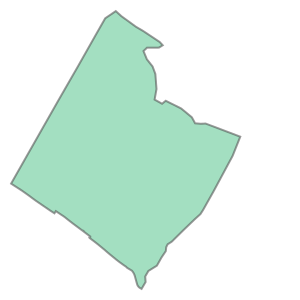

In [34]:
poly

#### Function for reading shape files and converting them to dataframe

In [35]:

def read_shapefile(sf):
#fetching the headings from the shape file
    fields = [x[0] for x in sf.fields][1:]
#fetching the records from the shape file
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
#converting shapefile data into pandas dataframe
    df = pd.DataFrame(columns=fields, data=records)
#assigning the coordinates
    df = df.assign(coords=shps)
    return df

## Read shape file for Wijken(neighborhoods)
wijken_df=read_shapefile(wijken)
## Read shape file for Woonbuurt(Residential area)
wnbrt_df=read_shapefile(woonbrt)
## Read shape file for Gemeente(Municipality)
gem_df=read_shapefile(gemeenten)

In [36]:
wijken_df.head()

,WK_CODE,JRSTATCODE,WK_NAAM,GM_CODE,GM_NAAM,IND_WBI,WATER,OAD,STED,BEV_DICHTH,...,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,OPP_TOT,OPP_LAND,OPP_WATER,Shape_Leng,Shape_Area,coords
0,WK001099,2020WK001099,,GM0010,Delfzijl,-99999999,JA,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,128728.007061,9.129235e+07,"[(268674.30900000036, 592382.3310000002), (268..."
1,WK003499,2020WK003499,,GM0034,Almere,-99999999,JA,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,122665.358634,1.095623e+08,"[(150213.99799999967, 479503.7259999998), (150..."
2,WK005099,2020WK005099,,GM0050,Zeewolde,-99999999,JA,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,83290.773617,1.633050e+07,"[(154927.5348000005, 474979.2899999991), (1549..."
3,WK006099,2020WK006099,,GM0060,Ameland,-99999999,JA,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,156406.894023,2.085914e+08,"[(196000.0, 610000.0), (196000.0, 608000.0), (..."
4,WK007299,2020WK007299,,GM0072,Harlingen,-99999999,JA,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,104274.683036,3.618323e+08,"[(158392.77529999986, 580357.5003000014), (158..."


#### Get only Alkmaar's neighborhoods

In [37]:

alkmaar_wijken=wijken_df[wijken_df.GM_NAAM == 'Alkmaar']

In [38]:
alkmaar_wijken

,WK_CODE,JRSTATCODE,WK_NAAM,GM_CODE,GM_NAAM,IND_WBI,WATER,OAD,STED,BEV_DICHTH,...,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,OPP_TOT,OPP_LAND,OPP_WATER,Shape_Leng,Shape_Area,coords
891,WK036101,2020WK036101,Zuid,GM0361,Alkmaar,1,NEE,3239,1,5687,...,1,1,3,4,261,255,6,7336.905891,2.612087e+06,"[(110541.5998999998, 516290.20010000095), (110..."
892,WK036102,2020WK036102,Oudorp,GM0361,Alkmaar,1,NEE,2073,2,2345,...,1,1,2,6,636,586,50,13803.510856,6.356351e+06,"[(113155.39990000054, 517786.4001000002), (113..."
893,WK036103,2020WK036103,Overdie,GM0361,Alkmaar,1,NEE,2284,2,1390,...,1,2,13,12,616,572,43,10564.850863,6.156385e+06,"[(111696.29989999905, 514962.0001000017), (111..."
894,WK036104,2020WK036104,West,GM0361,Alkmaar,1,NEE,2042,2,2009,...,1,1,3,6,637,606,32,14038.619734,6.370845e+06,"[(109477.1154000014, 515525.63870000094), (109..."
895,WK036105,2020WK036105,Huiswaard,GM0361,Alkmaar,1,NEE,2178,2,6965,...,1,2,2,9,114,109,6,4519.160397,1.144189e+06,"[(111486.39999999851, 517714.5001000017), (111..."
896,WK036106,2020WK036106,De Mare,GM0361,Alkmaar,1,NEE,2231,2,5717,...,2,2,1,8,295,275,20,9080.313487,2.948551e+06,"[(111737.9998999983, 519159.5), (111670.100000..."
897,WK036107,2020WK036107,Daalmeer/Koedijk,GM0361,Alkmaar,1,NEE,1802,2,4012,...,1,2,1,6,344,326,18,11335.603646,3.440444e+06,"[(111474.4112999998, 521734.7793999985), (1115..."
898,WK036108,2020WK036108,Centrum,GM0361,Alkmaar,1,NEE,3867,1,7146,...,1,1,1,5,133,120,13,6009.920109,1.330690e+06,"[(111323.5998999998, 516483.5001000017), (1112..."
899,WK036109,2020WK036109,Schermer,GM0361,Alkmaar,1,NEE,149,5,90,...,0,0,0,2,6439,6127,312,40910.712637,6.439078e+07,"[(113428.69999999925, 514530.5001000017), (113..."
900,WK036110,2020WK036110,Graft-De Rijp,GM0361,Alkmaar,1,NEE,423,5,325,...,0,1,0,2,2176,1993,183,23322.054985,2.175810e+07,"[(114718.89999999851, 507666.20010000095), (11..."


#### Inspect the data

In [39]:
alkmaar_wijken.columns

Index(['WK_CODE', 'JRSTATCODE', 'WK_NAAM', 'GM_CODE', 'GM_NAAM', 'IND_WBI',
       'WATER', 'OAD', 'STED', 'BEV_DICHTH', 'AANT_INW', 'AANT_MAN',
       'AANT_VROUW', 'P_00_14_JR', 'P_15_24_JR', 'P_25_44_JR', 'P_45_64_JR',
       'P_65_EO_JR', 'P_ONGEHUWD', 'P_GEHUWD', 'P_GESCHEID', 'P_VERWEDUW',
       'AANTAL_HH', 'P_EENP_HH', 'P_HH_Z_K', 'P_HH_M_K', 'GEM_HH_GR',
       'P_WEST_AL', 'P_N_W_AL', 'P_MAROKKO', 'P_ANT_ARU', 'P_SURINAM',
       'P_TURKIJE', 'P_OVER_NW', 'OPP_TOT', 'OPP_LAND', 'OPP_WATER',
       'Shape_Leng', 'Shape_Area', 'coords'],
      dtype='object')

##### Drop some columns for now

In [40]:
alkmaar_wijken = alkmaar_wijken[['WK_CODE','GM_NAAM','WK_NAAM','AANT_INW','OPP_TOT', 'OPP_LAND', 'OPP_WATER','coords']] 

##### Declare the Coordinate Reference system for The Netherlands so we can convert points to lat long coordinates

In [41]:

crs_proj=CRS('EPSG:28992')
crs_proj

<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [42]:
## Convert coordinates to Latitude, longitude and add its column to dataframe 

crs_4326 = CRS("WGS84")
transformer = pyproj.Transformer.from_crs(crs_proj,crs_4326, always_xy=True)
latlon_list=[]
for i,r in alkmaar_wijken.iterrows():
    coords_list=[]
    for n in range(len(alkmaar_wijken.loc[i].coords)):
        (lon,lat)=transformer.transform(alkmaar_wijken.loc[i].coords[n][0],alkmaar_wijken.loc[i].coords[n][1])
        coords_list.append((lat,lon))
    latlon_list.append(coords_list)
alkmaar_wijken['latlon']=latlon_list

In [43]:
alkmaar_wijken


,WK_CODE,GM_NAAM,WK_NAAM,AANT_INW,OPP_TOT,OPP_LAND,OPP_WATER,coords,latlon
891,WK036101,Alkmaar,Zuid,14510,261,255,6,"[(110541.5998999998, 516290.20010000095), (110...","[(52.632305375519344, 4.730514402070989), (52...."
892,WK036102,Alkmaar,Oudorp,13730,636,586,50,"[(113155.39990000054, 517786.4001000002), (113...","[(52.645958099156715, 4.76893148444471), (52.6..."
893,WK036103,Alkmaar,Overdie,7960,616,572,43,"[(111696.29989999905, 514962.0001000017), (111...","[(52.620462351559276, 4.747742744664198), (52...."
894,WK036104,Alkmaar,West,12165,637,606,32,"[(109477.1154000014, 515525.63870000094), (109...","[(52.62534672608974, 4.714896980535751), (52.6..."
895,WK036105,Alkmaar,Huiswaard,7570,114,109,6,"[(111486.39999999851, 517714.5001000017), (111...","[(52.64518120483112, 4.744282123193029), (52.6..."
896,WK036106,Alkmaar,De Mare,15720,295,275,20,"[(111737.9998999983, 519159.5), (111670.100000...","[(52.65818680142111, 4.747810617389989), (52.6..."
897,WK036107,Alkmaar,Daalmeer/Koedijk,13090,344,326,18,"[(111474.4112999998, 521734.7793999985), (1115...","[(52.68130854406547, 4.743576400390542), (52.6..."
898,WK036108,Alkmaar,Centrum,8560,133,120,13,"[(111323.5998999998, 516483.5001000017), (1112...","[(52.6341057166711, 4.7420390776183865), (52.6..."
899,WK036109,Alkmaar,Schermer,5520,6439,6127,312,"[(113428.69999999925, 514530.5001000017), (113...","[(52.616719470413585, 4.773377588109166), (52...."
900,WK036110,Alkmaar,Graft-De Rijp,6470,2176,1993,183,"[(114718.89999999851, 507666.20010000095), (11...","[(52.55512857687524, 4.793259122203652), (52.5..."


##### Get a list of Wijk names for each row's latlon point, and then add a column for Wijk in the positions dataframe

In [44]:
wijk_name_lst=[]
def get_Wijk(df):
    for index,value in df.latlon.items(): 
        p= Point(df.loc[index].Latitude,df.loc[index].Longitude)
        for (i,locs) in alkmaar_wijken.latlon.items():
            coord= alkmaar_wijken.loc[i].latlon
            poly= Polygon(coord)
            if p.within(poly):
                wijk_name=alkmaar_wijken.loc[i].WK_NAAM
        wijk_name_lst.append(wijk_name)   
    return wijk_name_lst

In [45]:
#Data.pos_2021[0]['Wijk']=get_Wijk(Data.pos_2021[0])

In [46]:
#Data.pos_2020[0]['Wijk']=get_Wijk(Data.pos_2020[0])